Author: Vincent T. Cooper  

Date: 1 December 2021  

Data preprocessing supporting the analysis in JGR Oceans manuscript submission.  

Purpose 1: Calculate the distance inside the ice edge from satellite SIC.

In [3]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpl.path.Path(verts * radius + center)

In [4]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
#     lats = iceconc_input.TLAT.values # cice version
#     lons = iceconc_input.TLON.values # cice version
    lats = iceconc_input.latitude.values # wavewatch version
    lons = iceconc_input.longitude.values # wavewatch version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point


    return(distances)

# SIC data from NOAA/NSIDC Climate Data Record (CDR)

- Preprocessing 2020 data from NSIDC
- Because of CDO problem with 2020 data when trying to regrid onto cice grid,
  we need to keep 2019 likeness but replace with 2020 values, then regrid to cice
- The cice regridding is done in terminal with CDO

In [73]:
# satdir2020 = '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/'
# sat_2020 = 'seaice_conc_daily_nh_2020_f17_v04r00.nc'
# tempsat2020 = xr.open_dataset(satdir2020 + sat_2020)

# satdir2019 = '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2019download/'
# sat_2019 = 'seaice_conc_daily_nh_2019.nc'
# tempsat2019 = xr.open_dataset(satdir2019 + sat_2019)

# tempsat2020['longitude'] = (['y','x'],tempsat2019.longitude.values)
# tempsat2020['latitude'] = (['y','x'],tempsat2019.latitude.values)
# tempsat2020 = tempsat2020.set_coords(['time','latitude','longitude'])

In [62]:
# ## manually creating 2020 dataset in likeness of 2019 dataset to enable cdo regridding
# ## and adjusting for extra leap day.
# ## Error in CDO occurring because it is recognizing the grid as something funny,
# ## even though it should be the same in the 2019 data.

# ## steps are: copy the 2019 data (365 days of it) but replace the concentration
# ## values with the 2020 data. Then replace the time variable with the 2020 times.
# ## Finally, concatenate an extra day of 12-31 because of leap year.
# ## Repeat this for each of the three concentration datasets (cdr,bt,nt).

# ## CDR
# temp = xr.DataArray(tempsat2020.cdr_seaice_conc[0:-1].values,
#               dims=tempsat2019.seaice_conc_cdr.dims,
#               coords=tempsat2019.seaice_conc_cdr.coords,
#                    name=tempsat2019.seaice_conc_cdr.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.cdr_seaice_conc[-1].values,
#               dims=tempsat2019.seaice_conc_cdr[0].dims,
#               coords=tempsat2019.seaice_conc_cdr[-1].coords,
#                          name=tempsat2019.seaice_conc_cdr.name)
# extra_day['time'] = tempsat2020.time[-1]
# cdr = xr.concat([temp,extra_day],dim='time')

# ## NT
# temp = xr.DataArray(tempsat2020.nsidc_nt_seaice_conc[0:-1].values,
#               dims=tempsat2019.goddard_nt_seaice_conc.dims,
#               coords=tempsat2019.goddard_nt_seaice_conc.coords,
#                    name=tempsat2019.goddard_nt_seaice_conc.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.nsidc_nt_seaice_conc[-1].values,
#               dims=tempsat2019.goddard_nt_seaice_conc[0].dims,
#               coords=tempsat2019.goddard_nt_seaice_conc[-1].coords,
#                          name=tempsat2019.goddard_nt_seaice_conc.name)
# extra_day['time'] = tempsat2020.time[-1]
# nt = xr.concat([temp,extra_day],dim='time')

# ## BT
# temp = xr.DataArray(tempsat2020.nsidc_bt_seaice_conc[0:-1].values,
#               dims=tempsat2019.goddard_bt_seaice_conc.dims,
#               coords=tempsat2019.goddard_bt_seaice_conc.coords,
#                    name=tempsat2019.goddard_bt_seaice_conc.name)
# temp['time'] = tempsat2020.time[0:-1]
# extra_day = xr.DataArray(tempsat2020.nsidc_bt_seaice_conc[-1].values,
#               dims=tempsat2019.goddard_bt_seaice_conc[0].dims,
#               coords=tempsat2019.goddard_bt_seaice_conc[-1].coords,
#                          name=tempsat2019.goddard_bt_seaice_conc.name)
# extra_day['time'] = tempsat2020.time[-1]
# bt = xr.concat([temp,extra_day],dim='time')

# sat2020 = xr.merge([cdr,nt,bt])

In [74]:
# ## save the 2020 data on the 2019 grid details

# sat2020.to_netcdf(satdir2020 + 'seaice_conc_daily_nh_2020_ondummy2019grid.nc')
# print('finished saving')

finished saving


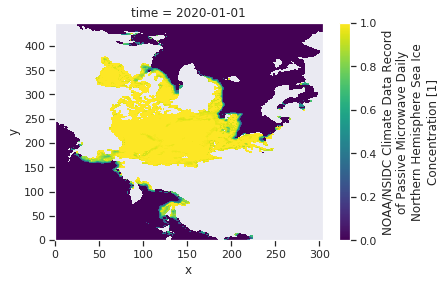

In [35]:
## add one more day onto 2019 data, then replace it with 2020

In [26]:
tempsat2020.to_netcdf(satdir2020 + 'seaice_conc_daily_nh_2020_f17_latlon.nc')
print('finished saving')

finished saving


In [81]:
## check regridded vs native
# xr.open_dataset('')
!ls /glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/seaice_conc_daily_nh_2020_cicegrid.nc

2019.grd
README.txt
seaice_conc_daily_nh_2020_cicegrid.nc
seaice_conc_daily_nh_2020_f17_v04r00.nc
seaice_conc_daily_nh_2020_ondummy2019grid.nc


In [ ]:
newgrid = xr.open_dataset('/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/2020download/seaice_conc_daily_nh_2020_cicegrid.nc')

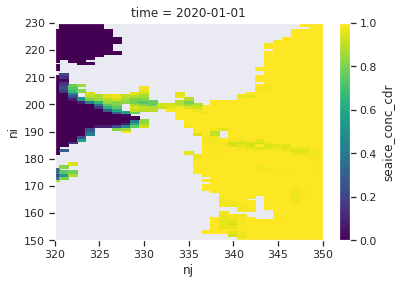

(-3000000.0, -1000000.0)

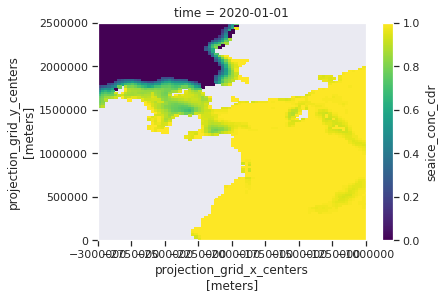

In [100]:
newgrid.seaice_conc_cdr[0].plot(x='nj',y='ni')
plt.xlim(320,350)
plt.ylim(150,230)
plt.show()

# sat2020.seaice_conc_cdr[0].plot(x='longitude',y='latitude')
sat2020.seaice_conc_cdr[0].plot()
plt.ylim(0,2.5e6)
plt.xlim(-3e6,-1e6)

#### Continue using data before

In [75]:
cdr = xr.open_dataset(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/BGEP_vtc_backup20210120/regrid_sat/seaice_conc_daily_nh_1979-2019.nc').sel(time=slice('2012','2019'))

In [79]:
## example
isel=-85
tempice = cdr.seaice_conc_cdr[isel]
tempdist = icedistance(tempice)
tempdist = xr.DataArray(tempdist, dims = cdr.seaice_conc_cdr[isel].dims,
            coords = cdr.seaice_conc_cdr[isel].coords).rename('dist')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


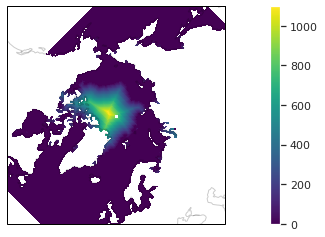

In [80]:
fig,ax = plt.subplots(1,1,figsize=(16,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
#                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=190-360)})

# plt.sca(ax[aind])
ax.coastlines(alpha=0.2,lw=1)
ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
# ax.set_extent([-174,-142,65,82], ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND)

plt.pcolormesh(cdr.longitude,cdr.latitude,
               tempdist,
               transform=ccrs.PlateCarree(),
              cmap='viridis')

plt.colorbar()
plt.show()

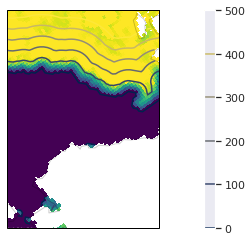

In [82]:
fig,ax = plt.subplots(1,1,figsize=(16,4),#subplot_kw={'projection': ccrs.NorthPolarStereo()})
                      subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=190-360)})

# plt.sca(ax[aind])
ax.coastlines(alpha=0.2,lw=1)
# ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
ax.set_extent([-172,-142,65,82], ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND)

plt.pcolormesh(cdr.longitude,cdr.latitude,
               cdr.seaice_conc_cdr[isel],
               transform=ccrs.PlateCarree(),
              cmap=cmo)

levset = np.arange(0,501,100)
cmapset = 'cividis'
plt.contour(cdr.longitude,cdr.latitude,
             tempdist.where(tempdist.longitude < 0),
             levels=levset,
             transform=ccrs.PlateCarree(),
             cmap=cmapset)

plt.contour(cdr.longitude,cdr.latitude,
             tempdist.where(tempdist.longitude > 0),
             levels=levset,
             transform=ccrs.PlateCarree(),
             cmap=cmapset)

plt.colorbar()
plt.show()